In [2]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from icecream import ic

import torch
from torch import nn
import torchvision.transforms as transforms
import kornia

import coremltools as ct

## some util
def print_img_stats(*imgs):
    for img in imgs:
        print(img.shape, img.min(), img.max())
        
def load_uint8_img(img_path):
    """load img as uint8"""
    img = plt.imread(img_path)
    if img.max() < 100: # float
        img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    else:
        img = np.clip(img, 0, 255).astype(np.uint8)
    return img

In [3]:
torch.__version__ # 1.13

'1.13.1'

In [4]:
## https://github.com/pytorch/pytorch/issues/101777#issuecomment-1553380545
## have to use earlier version of kornia which doesnt use new python feature
kornia.__version__ # 0.6.10

'0.6.10'

In [5]:
def plot_tensor_image_grid(img_list, n_per_row, titles=None, figsize=(15,10), 
                           untransform=None, transpose=False):
    """
    plt version of torchvision make_grid (via plt.subplots+untransform)
    + title 
    + figsize
    (can add plt.suptitle outside)

    args:
    img_list: list of img as tensor
    transpose: if True, go vertically down first
    """
    assert len(img_list) > 0
    if titles:
        assert len(img_list) == len(titles)
    n_row = (len(img_list)-1) // n_per_row + 1
    fig, axes = plt.subplots(n_row, n_per_row, figsize=figsize, 
                            squeeze=False, constrained_layout=True)
    for i, img in enumerate(img_list):
        if not transpose:
            if untransform:
                axes[i//n_per_row, i%n_per_row].imshow(untransform(img))
            else:
                axes[i//n_per_row, i%n_per_row].imshow(img)
            axes[i//n_per_row, i%n_per_row].axis("off")
            if titles:
                axes[i//n_per_row, i%n_per_row].set_title(titles[i])
        else:
            if untransform:
                axes[i%n_row, i//n_row].imshow(untransform(img))
            else:
                axes[i%n_row, i//n_row].imshow(img)
            axes[i%n_row, i//n_row].axis("off")
            if titles:
                axes[i%n_row, i//n_row].set_title(titles[i])
    for i in range(len(img_list), n_row*n_per_row):
        if not transpose:
            axes[i//n_per_row, i%n_per_row].axis("off")
        else:
            axes[i%n_row, i//n_row].axis("off")

# Color threshold bbox

In [81]:
# color thresholding: https://colorizer.org
R,C,_c = 5,3,1
plt.figure(figsize=(12,16))

# load cropped img
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/5342.jpg"
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/2714.jpg"
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/1215.jpg"
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/2691.jpg"
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/3244.jpg"
img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/0.jpg"

img = plt.imread(img_path)
print_img_stats(img)
plt.subplot(R,C,_c); _c+=C
plt.imshow(img)
plt.title("homography fixed")

############################ background mask
### define color filter
_img = (img / 255).astype(np.float32)
img_hsv = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV_FULL) # 0-360, 0-1, 0-1
mask = cv2.inRange(img_hsv, 
                      (75, 0., 0.), 
                      (200,1, 0.45))
mask = mask / 255
plt.subplot(R,C,_c); _c+=1
plt.imshow(mask,"gray")
plt.title("bg mask")
print(mask.mean())

# remove active noise in mask
kernel = np.ones((3,3),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=3)
# kernel = np.ones((3,3),np.uint8)
mask = cv2.dilate(mask, kernel, iterations=3)
plt.subplot(R,C,_c); _c+=1
plt.imshow(mask,"gray")
plt.title("bg mask w/ morph")
print(mask.mean())

# show bg area
img_bg = img.copy()
img_bg[~ mask.astype(bool)] = 0
plt.subplot(R,C,_c); _c+=1
plt.imshow(img_bg)
plt.title("bg area")

############################ foreground mask for white part
# fg mask
img_hsv = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV_FULL) # 0-360, 0-1, 0-1
fg_mask = cv2.inRange(img_hsv,  (0,  0, 0.55), 
                                (360,0.14, 1))
fg_mask = fg_mask / 255
plt.subplot(R,C,_c); _c+=1
plt.imshow(fg_mask,"gray")
plt.title("fg mask")
print(fg_mask.mean())

# remove active noise in mask
kernel = np.ones((3,3),np.uint8)
fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel, iterations=3)
# kernel = np.ones((3,3),np.uint8)
fg_mask = cv2.erode(fg_mask, kernel, iterations=1)
plt.subplot(R,C,_c); _c+=1
plt.imshow(fg_mask,"gray")
plt.title("bg mask w/ morph")
print(fg_mask.mean())

# show fg area
img_fg = img.copy()
img_fg[~ fg_mask.astype(bool)] = 0
plt.subplot(R,C,_c); _c+=1
plt.imshow(img_fg)
plt.title("fg area")
############################


############################ foreground mask for color part
# fg mask 2: purple
img_hsv2 = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV_FULL) # 0-360, 0-1, 0-1
fg_mask2 = cv2.inRange(img_hsv2, 
                      (250, 0.3, 0.20), 
                      (310, 1, 0.95))

fg_mask2 = fg_mask2 / 255
plt.subplot(R,C,_c); _c+=1
plt.imshow(fg_mask2,"gray")
plt.title("fg mask 2")
print(fg_mask2.mean())

# remove active noise in mask2
kernel = np.ones((3,3),np.uint8)
fg_mask2 = cv2.morphologyEx(fg_mask2, cv2.MORPH_OPEN, kernel, iterations=3)
# kernel = np.ones((3,3),np.uint8)
fg_mask2 = cv2.erode(fg_mask2, kernel, iterations=1)
plt.subplot(R,C,_c); _c+=1
plt.imshow(fg_mask2,"gray")
plt.title("bg mask 2 w/ morph")
print(fg_mask2.mean())

# show fg area 2
img_fg = img.copy()
img_fg[~ fg_mask2.astype(bool)] = 0
plt.subplot(R,C,_c); _c+=1
plt.imshow(img_fg)
plt.title("fg area 2")
############################

############################ draw bbox
img_bbox = img.copy()
fg_mask_all = fg_mask.astype(bool) | fg_mask2.astype(bool)
y_coords, x_coords = np.nonzero(fg_mask_all)
x0, x1 = np.min(x_coords), np.max(x_coords)
y0, y1 = np.min(y_coords), np.max(y_coords)
img_bbox = cv2.rectangle(img_bbox, (x0,y0), (x1,y1), color=(0,255,0), thickness=20)
plt.subplot(R,C,_c); _c+=1
plt.imshow(img_bbox)
plt.title("bbox from fg mask")
############################

plt.show()
# Image.fromarray(img_masked_w_text_fg_change).save("temp2.jpg")

(800, 1200, 3) 0 255
0.7275875
0.73535625
0.26248958333333333
0.2565125
0.0
0.0
[730 731 732 ... 535 536 537]


In [218]:
def color_threshold_bbox(img):
    img = (img / 255).astype(np.float32)
    ## foreground mask for white part
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV_FULL) # 0-360, 0-1, 0-1
    fg_mask = cv2.inRange(img_hsv,  (0,  0, 0.55), 
                                    (360,0.14, 1))
    fg_mask = fg_mask / 255
    
    # remove active noise in mask
    kernel = np.ones((3,3),np.uint8)
    fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel, iterations=3)
    fg_mask = cv2.erode(fg_mask, kernel, iterations=1)

    ## foreground mask for color part
    # fg mask 2: purple
    fg_mask2 = cv2.inRange(img_hsv, 
                          (250, 0.3, 0.20), 
                          (310, 1, 0.95))
    fg_mask2 = fg_mask2 / 255

    # remove active noise in mask2
    kernel = np.ones((3,3),np.uint8)
    fg_mask2 = cv2.morphologyEx(fg_mask2, cv2.MORPH_OPEN, kernel, iterations=3)
    fg_mask2 = cv2.erode(fg_mask2, kernel, iterations=1)

    ## bbox from color mask
    fg_mask_all = fg_mask.astype(bool) | fg_mask2.astype(bool)
    y_coords, x_coords = np.nonzero(fg_mask_all)
    x0, x1 = np.min(x_coords), np.max(x_coords)
    y0, y1 = np.min(y_coords), np.max(y_coords)
    return [x0,y0,x1,y1]

## Visualize bbox

In [64]:
label = np.load("data/dog_p_on_g_anno_homog/frame_label.npz")
frame_indices = label['frame_indices']
labels = label["labels"]

label2frames = {}
for label, ind in zip(labels, frame_indices):
    if label not in label2frames:
        label2frames[label] = []
    label2frames[label].append(ind)
for i in range(len(label2frames)):
    label2frames[i].sort()
# label2frames[1]

ic| len(img_list): 8


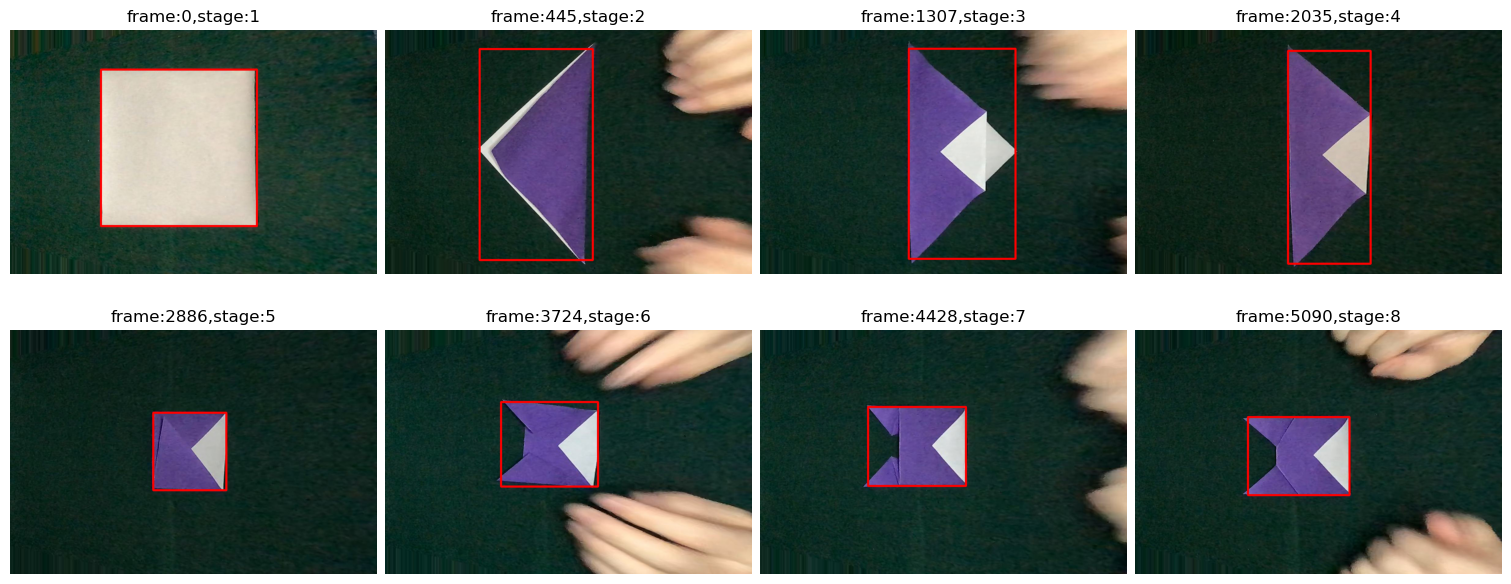

In [95]:
# visualize each stage
foldername = "data/dog_p_on_g_anno_homog"
img_list = []
title_list = []
for i in range(1,9):
    frame_index = label2frames[i][0]
    img = load_uint8_img(f"{foldername}/{frame_index}.jpg") 
    bbox = color_threshold_bbox(img)
    x1,y1,x2,y2 = bbox
#     x1,y1, w,h = int(x1), int(y1), int(w), int(h)
    cv2.rectangle(img, (x1,y1), (x2,y2), color=(255,0,0), thickness=5)
    img_list.append(img)
    title_list.append(f"frame:{frame_index},stage:{i}")
ic(len(img_list))
plot_tensor_image_grid(img_list, 4, titles=title_list, figsize=(15,6), transpose=False) 
# plt.savefig("anno_bbox_color-threshold.png", dpi=250)
# plt.show()

In [94]:
# visualize each stage
foldername = "data/dog_p_on_g_anno_homog"
img_list = []
title_list = []
for frame_index in [5019,4991,281,2721,4773,4974,3448,3349]:
    img = load_uint8_img(f"{foldername}/{frame_index}.jpg") 
    bbox = color_threshold_bbox(img)
    x1,y1,x2,y2 = bbox
#     x1,y1, w,h = int(x1), int(y1), int(w), int(h)
    cv2.rectangle(img, (x1,y1), (x2,y2), color=(255,0,0), thickness=5)
    img_list.append(img)
    title_list.append(f"frame:{frame_index},stage:{i}")
ic(len(img_list))
plot_tensor_image_grid(img_list, 4, titles=title_list, figsize=(15,6), transpose=False) 
# plt.savefig("anno_bbox_color-threshold.png", dpi=250)
# plt.show()

ic| len(img_list): 8


# Pytorch color threshold detection model

In [88]:
## the np target
def color_threshold_bbox_test(img):
    img = img.astype(np.float32) / 255
    ## foreground mask for white part
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV_FULL) # 0-360, 0-1, 0-1
    fg_mask = cv2.inRange(img_hsv,  (0,  0, 0.55), 
                                    (360,0.14, 1))
    fg_mask = fg_mask / 255
    
    # remove active noise in mask
    kernel = np.ones((3,3),np.uint8)
    fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel, iterations=3)
    fg_mask = cv2.erode(fg_mask, kernel, iterations=1)
    print(len(np.nonzero(fg_mask)[0]))

    ## foreground mask for color part
    # fg mask 2: purple
    fg_mask2 = cv2.inRange(img_hsv, 
                          (250, 0.3, 0.20), 
                          (310, 1, 0.95))
    fg_mask2 = fg_mask2 / 255

    # remove active noise in mask2
    kernel = np.ones((3,3),np.uint8)
    fg_mask2 = cv2.morphologyEx(fg_mask2, cv2.MORPH_OPEN, kernel, iterations=3)
    fg_mask2 = cv2.erode(fg_mask2, kernel, iterations=1)
    print(len(np.nonzero(fg_mask2)[0]))

    ## bbox from color mask
    fg_mask_all = fg_mask.astype(bool) | fg_mask2.astype(bool)
    y_coords, x_coords = np.nonzero(fg_mask_all)
    print(y_coords, y_coords.shape)
    print(x_coords, x_coords.shape)
    x0, x1 = np.min(x_coords), np.max(x_coords)
    y0, y1 = np.min(y_coords), np.max(y_coords)
    return [x0,y0,x1,y1]

In [6]:
## Cannot use kornia since its operation are not supported by coreml
## so implement pytorch version of erode and dilate following
## https://stackoverflow.com/questions/56235733/is-there-a-tensor-operation-or-function-in-pytorch-that-works-like-cv2-dilate

## need to annotate input, since it expects tensor otherwise:   
## https://discuss.pytorch.org/t/how-to-correctly-use-the-pad-function-in-torchscript/141287/2
## use python3 type hint:
## https://pytorch.org/docs/stable/jit_language_reference.html#default-types
@torch.jit.script 
def dilate(im_tensor: torch.Tensor, kernel_size: int=3) -> torch.Tensor:
    """
    img: [1, 1, H, W]
    """
    padding = kernel_size // 2
    kernel_tensor = torch.ones(1,1, kernel_size, kernel_size, dtype=im_tensor.dtype)
    torch_result2 = torch.nn.functional.conv2d(im_tensor, kernel_tensor, padding=[padding,padding])
    torch_result_final = torch.clamp(torch_result2, 0., 1.)
    return torch_result_final

# dilate = torch.jit.trace(dilate, (torch.rand(1,1,800,1200), torch.tensor(3))) # cannot trace since trace only work on tensors

@torch.jit.script
def erode(im_tensor: torch.Tensor, kernel_size: int=3) -> torch.Tensor:
    """
    img: [1, 1, H, W]
    """
    padding = kernel_size // 2
    kernel_tensor = torch.ones(1,1, kernel_size, kernel_size)
    torch_result = torch.nn.functional.conv2d(im_tensor, kernel_tensor, padding=[padding,padding])
    torch_result = (torch_result == kernel_size**2).to(torch.float32)
    return torch_result

# dilate = torch.jit.trace(erode, (torch.rand(1,1,800,1200), torch.tensor(3)))

In [7]:
class OrigamiPaperDetectionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hsv_lower_white = torch.tensor([0,  0, 0.55], dtype=torch.float)
        self.hsv_upper_white = torch.tensor([360,0.14, 1], dtype=torch.float)
        self.hsv_lower_color = torch.tensor([250, 0.3, 0.20], dtype=torch.float)
        self.hsv_upper_color = torch.tensor([310, 1, 0.95], dtype=torch.float)
        for bound in [self.hsv_lower_white, self.hsv_upper_white, \
                      self.hsv_lower_color, self.hsv_upper_color]: # in range [0,0,0]-[2pi,1,1]
            bound[0] = bound[0] / 180 * torch.pi
            
#         # cv2 morphology is equivalent to kornia morphology without iteration 
#         # for basic morphological operations, with rectangular kernels and odd-dimensioned ones
#         # https://stackoverflow.com/questions/45070004/iterations-vs-kernel-size-in-morphological-operations-opencv
#         self.morph_open_kernel_white = torch.ones(7, 7)
#         self.morph_erode_kernel_white = torch.ones(3, 3)
#         self.morph_open_kernel_color = torch.ones(7, 7)
#         self.morph_erode_kernel_color = torch.ones(3, 3)
#         self.border_type = "constant" # "geodesic"

    def dilate(self, im_tensor: torch.Tensor, kernel_size: int=3) -> torch.Tensor:
        """
        img: [1, 1, H, W]
        """
        padding = kernel_size // 2
        kernel_tensor = torch.ones(1,1, kernel_size, kernel_size, dtype=im_tensor.dtype)
        torch_result2 = torch.nn.functional.conv2d(im_tensor, kernel_tensor, padding=[padding,padding])
        torch_result_final = torch.clamp(torch_result2, 0., 1.)
        return torch_result_final
    
    def forward(self, img):
        """
        img: [B,3,H,W] in range 0-1
        """
#         img_hsv = kornia.color.rgb_to_hsv(img) # [B,3,H,W] The H channel are in the range 0..2pi. S and V are in the range 0..1.
#         return img_hsv
        img = (img[:,:1]>1).to(torch.bool).to(torch.float32)
        return self.dilate(img, 3)
#         im_tensor = img
#         kernel_size = 3
#         padding = kernel_size // 2
#         kernel_tensor = torch.ones(1,1, kernel_size, kernel_size, dtype=im_tensor.dtype)
#         torch_result2 = torch.nn.functional.conv2d(im_tensor, kernel_tensor, padding=[padding,padding])
#         torch_result_final = torch.clamp(torch_result2, 0., 1.)
#         return torch_result_final

#         B = 1 #img.shape[0]
        
#         ## mask for white 
#         white_mask_h = (self.hsv_lower_white[0] <= img_hsv[:,0]) & (img_hsv[:,0] <= self.hsv_upper_white[0])
#         white_mask_s = (self.hsv_lower_white[1] <= img_hsv[:,1]) & (img_hsv[:,1] <= self.hsv_upper_white[1])
#         white_mask_v = (self.hsv_lower_white[2] <= img_hsv[:,2]) & (img_hsv[:,2] <= self.hsv_upper_white[2])
#         white_mask = white_mask_h & white_mask_s & white_mask_v # [B,H,W]
#         white_mask = white_mask.unsqueeze(1).to(torch.float32) # [B,1,H,W]
#         white_mask = kornia.morphology.opening(white_mask, self.morph_open_kernel_white, border_type=self.border_type)
#         white_mask = kornia.morphology.erosion(white_mask, self.morph_erode_kernel_white,border_type=self.border_type)
# #         print("white_mask:", torch.nonzero(white_mask).shape[0])
         
#         ## mask for purple
#         color_mask_h = (self.hsv_lower_color[0] <= img_hsv[:,0]) & (img_hsv[:,0] <= self.hsv_upper_color[0])
#         color_mask_s = (self.hsv_lower_color[1] <= img_hsv[:,1]) & (img_hsv[:,1] <= self.hsv_upper_color[1])
#         color_mask_v = (self.hsv_lower_color[2] <= img_hsv[:,2]) & (img_hsv[:,2] <= self.hsv_upper_color[2])
#         color_mask = color_mask_h & color_mask_s & color_mask_v # [B,H,W]
#         color_mask = color_mask.unsqueeze(1).to(torch.float32) # [B,1,H,W]
#         color_mask = kornia.morphology.opening(color_mask, self.morph_open_kernel_color, border_type=self.border_type)
#         color_mask = kornia.morphology.erosion(color_mask, self.morph_erode_kernel_color,border_type=self.border_type)
# #         print("color_mask:", torch.nonzero(color_mask).shape[0])
# #         color_mask = torch.zeros_like(white_mask)
        
#         ## bbox from color mask
#         mask = white_mask.to(torch.bool) | color_mask.to(torch.bool) # [B,1,H,W]
#         mask = mask.squeeze(1)
        
# #         # using loop
# #         indices = torch.nonzero(mask) # [N,3] # as_tuple kwarg is not implemented in `torch.jit.script`
# #         bboxes = torch.zeros((B,4), dtype=torch.int) # [x,y,w,h]
# #         for ind in range(B):
# #             ind_mask = indices[:,0] == ind
# #             y_coords = indices[ind_mask,1]
# #             x_coords = indices[ind_mask,2]
# # #             print(y_coords, y_coords.shape)
# # #             print(x_coords, x_coords.shape)
# #             x0, x1 = x_coords.min(), x_coords.max()
# #             y0, y1 = y_coords.min(), y_coords.max()
# # #             print("torch x0,y0,x1,y1:",[x0.item(),y0.item(), x1.item(),y1.item()])
# #             w = x1 - x0
# #             h = y1 - y0
# #             bboxes[ind,0],bboxes[ind,1],bboxes[ind,2],bboxes[ind,3] = x0, y0, w, h

#         # using only the first img
        
#         indices = torch.nonzero(mask[0]) # [N,2]
#         y_coords, x_coords = indices[:,0], indices[:,1]
#         x0, x1 = x_coords.min(), x_coords.max()
#         y0, y1 = y_coords.min(), y_coords.max()
#         w = x1 - x0
#         h = y1 - y0
# #         print(x0, y0, w, h)
# #         bboxes = torch.tensor([x0, y0, w, h])
#         bboxes = torch.zeros((1,4), dtype=torch.int) # [x,y,w,h]
#         bboxes[0],bboxes[1],bboxes[2],bboxes[3] = x0, y0, w, h

#         classes = torch.ones(B)
#         return bboxes, classes
        
detector_scripted = torch.jit.script(OrigamiPaperDetectionModel())
detecor = detector_scripted

# detecor = OrigamiPaperDetectionModel()

In [198]:
# class OrigamiPaperDetectionModel(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.hsv_lower_white = torch.tensor([0,  0, 0.55], dtype=torch.float)
#         self.hsv_upper_white = torch.tensor([360,0.14, 1], dtype=torch.float)
#         self.hsv_lower_color = torch.tensor([250, 0.3, 0.20], dtype=torch.float)
#         self.hsv_upper_color = torch.tensor([310, 1, 0.95], dtype=torch.float)
#         for bound in [self.hsv_lower_white, self.hsv_upper_white, \
#                       self.hsv_lower_color, self.hsv_upper_color]: # in range [0,0,0]-[2pi,1,1]
#             bound[0] = bound[0] / 180 * torch.pi
            
#         # cv2 morphology is equivalent to kornia morphology without iteration 
#         # for basic morphological operations, with rectangular kernels and odd-dimensioned ones
#         # https://stackoverflow.com/questions/45070004/iterations-vs-kernel-size-in-morphological-operations-opencv
#         self.morph_open_kernel_white = torch.ones(7, 7)
#         self.morph_erode_kernel_white = torch.ones(3, 3)
#         self.morph_open_kernel_color = torch.ones(7, 7)
#         self.morph_erode_kernel_color = torch.ones(3, 3)
#         self.border_type = "constant" # "geodesic"
    
#     def forward(self, img):
#         """
#         img: [B,3,H,W] in range 0-1
#         """
#         img_hsv = kornia.color.rgb_to_hsv(img) # [B,3,H,W] The H channel are in the range 0..2pi. S and V are in the range 0..1.
#         B = 1 #img.shape[0]
        
#         ## mask for white 
#         white_mask_h = (self.hsv_lower_white[0] <= img_hsv[:,0]) & (img_hsv[:,0] <= self.hsv_upper_white[0])
#         white_mask_s = (self.hsv_lower_white[1] <= img_hsv[:,1]) & (img_hsv[:,1] <= self.hsv_upper_white[1])
#         white_mask_v = (self.hsv_lower_white[2] <= img_hsv[:,2]) & (img_hsv[:,2] <= self.hsv_upper_white[2])
#         white_mask = white_mask_h & white_mask_s & white_mask_v # [B,H,W]
#         white_mask = white_mask.unsqueeze(1).to(torch.float32) # [B,1,H,W]
#         white_mask = kornia.morphology.opening(white_mask, self.morph_open_kernel_white, border_type=self.border_type)
#         white_mask = kornia.morphology.erosion(white_mask, self.morph_erode_kernel_white,border_type=self.border_type)
# #         print("white_mask:", torch.nonzero(white_mask).shape[0])
         
#         ## mask for purple
#         color_mask_h = (self.hsv_lower_color[0] <= img_hsv[:,0]) & (img_hsv[:,0] <= self.hsv_upper_color[0])
#         color_mask_s = (self.hsv_lower_color[1] <= img_hsv[:,1]) & (img_hsv[:,1] <= self.hsv_upper_color[1])
#         color_mask_v = (self.hsv_lower_color[2] <= img_hsv[:,2]) & (img_hsv[:,2] <= self.hsv_upper_color[2])
#         color_mask = color_mask_h & color_mask_s & color_mask_v # [B,H,W]
#         color_mask = color_mask.unsqueeze(1).to(torch.float32) # [B,1,H,W]
#         color_mask = kornia.morphology.opening(color_mask, self.morph_open_kernel_color, border_type=self.border_type)
#         color_mask = kornia.morphology.erosion(color_mask, self.morph_erode_kernel_color,border_type=self.border_type)
# #         print("color_mask:", torch.nonzero(color_mask).shape[0])
# #         color_mask = torch.zeros_like(white_mask)
        
#         ## bbox from color mask
#         mask = white_mask.to(torch.bool) | color_mask.to(torch.bool) # [B,1,H,W]
#         mask = mask.squeeze(1)
        
# #         # using loop
# #         indices = torch.nonzero(mask) # [N,3] # as_tuple kwarg is not implemented in `torch.jit.script`
# #         bboxes = torch.zeros((B,4), dtype=torch.int) # [x,y,w,h]
# #         for ind in range(B):
# #             ind_mask = indices[:,0] == ind
# #             y_coords = indices[ind_mask,1]
# #             x_coords = indices[ind_mask,2]
# # #             print(y_coords, y_coords.shape)
# # #             print(x_coords, x_coords.shape)
# #             x0, x1 = x_coords.min(), x_coords.max()
# #             y0, y1 = y_coords.min(), y_coords.max()
# # #             print("torch x0,y0,x1,y1:",[x0.item(),y0.item(), x1.item(),y1.item()])
# #             w = x1 - x0
# #             h = y1 - y0
# #             bboxes[ind,0],bboxes[ind,1],bboxes[ind,2],bboxes[ind,3] = x0, y0, w, h

#         # using only the first img
        
#         indices = torch.nonzero(mask[0]) # [N,2]
#         y_coords, x_coords = indices[:,0], indices[:,1]
#         x0, x1 = x_coords.min(), x_coords.max()
#         y0, y1 = y_coords.min(), y_coords.max()
#         w = x1 - x0
#         h = y1 - y0
# #         print(x0, y0, w, h)
# #         bboxes = torch.tensor([x0, y0, w, h])
#         bboxes = torch.zeros((1,4), dtype=torch.int) # [x,y,w,h]
#         bboxes[0,0],bboxes[0,1],bboxes[0,2],bboxes[0,3] = x0, y0, w, h

#         classes = torch.ones(B)
#         return bboxes, classes
        
# detector_scripted = torch.jit.script(OrigamiPaperDetectionModel())
# detecor = detector_scripted

# # detecor = OrigamiPaperDetectionModel()

## test dilate /erode

In [184]:
sample_im_tensor = torch.zeros(1,1,7,7)
sample_im_tensor[0,0,3,3] = 1.
# dilate(sample_im_tensor, kernel_size=torch.tensor(3))
dilate(sample_im_tensor, kernel_size=3)

tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 1., 1., 0., 0.],
          [0., 0., 1., 1., 1., 0., 0.],
          [0., 0., 1., 1., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]])

In [138]:
sample_im_tensor = torch.ones(1,1,7,7)
sample_im_tensor[0,0,0,0] = 0
# erode(sample_im_tensor, kernel_size=torch.tensor(3))
erode(sample_im_tensor, kernel_size=3)

tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 1., 1., 1., 0.],
          [0., 1., 1., 1., 1., 1., 0.],
          [0., 1., 1., 1., 1., 1., 0.],
          [0., 1., 1., 1., 1., 1., 0.],
          [0., 1., 1., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]])

## Test detection result

In [51]:
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/0.jpg"
img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/445.jpg"
img = np.asarray(Image.open(img_path))
print(img.shape)
color_threshold_bbox_test(img)

(800, 1200, 3)
9416
111989
[ 65  65  65 ... 754 754 754] (121405,)
[668 669 670 ... 645 646 647] (121405,)


[309, 65, 679, 754]

In [52]:
img = np.asarray(Image.open(img_path)).astype(np.float32) / 255
img_torch = torch.tensor(img, dtype=torch.float32).permute(2,0,1)

detecor(img_torch[None])

(tensor([[309,  65, 370, 689]], dtype=torch.int32), tensor([1.]))

## Test visualization

In [13]:
label = np.load("data/dog_p_on_g_anno_homog/frame_label.npz")
frame_indices = label['frame_indices']
labels = label["labels"]

label2frames = {}
for label, ind in zip(labels, frame_indices):
    if label not in label2frames:
        label2frames[label] = []
    label2frames[label].append(ind)
for i in range(len(label2frames)):
    label2frames[i].sort()
# label2frames[1]

246252
0
[132 132 132 ... 643 643 643] (246252,)
[730 731 732 ... 535 536 537] (246252,)
np bbox: [297, 132, 807, 643]
--------------------------------
9416
111989
[ 65  65  65 ... 754 754 754] (121405,)
[668 669 670 ... 645 646 647] (121405,)
np bbox: [309, 65, 679, 754]
--------------------------------
28678
97211
[ 64  64  64 ... 750 750 750] (125889,)
[489 490 491 ... 502 503 504] (125889,)
np bbox: [486, 64, 835, 750]
--------------------------------
11181
101477
[ 71  71  71 ... 766 766 766] (112658,)
[504 505 506 ... 525 526 527] (112658,)
np bbox: [500, 71, 770, 766]
--------------------------------
13344
42335
[273 273 273 ... 526 526 526] (55679,)
[577 578 579 ... 685 686 687] (55679,)
np bbox: [468, 273, 707, 526]
--------------------------------
16002
45646
[238 238 238 ... 514 514 514] (61648,)
[401 402 403 ... 668 669 670] (61648,)
np bbox: [379, 238, 696, 514]
--------------------------------
12707
50970
[254 254 254 ... 512 512 512] (63677,)
[369 370 371 ... 380 381 382

ic| len(img_list): 8


--------------------------------


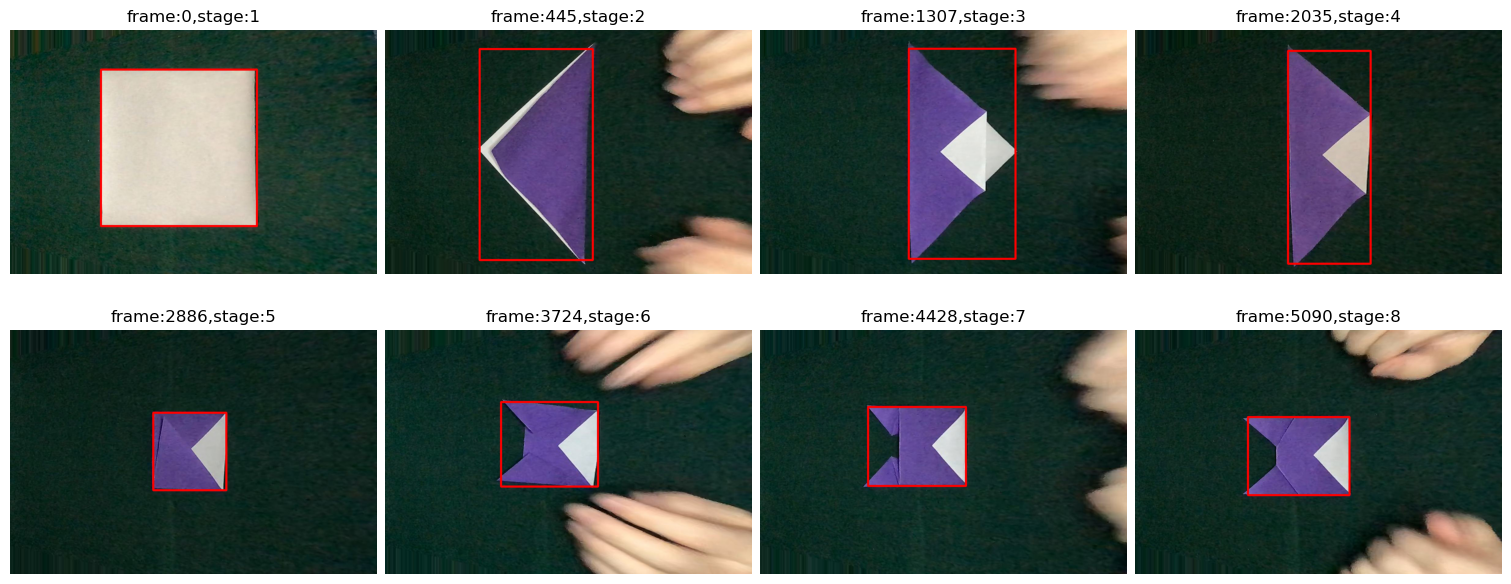

In [14]:
# visualize each stage
foldername = "data/dog_p_on_g_anno_homog"
img_list = []
title_list = []
img_list2 = []
for i in range(1,9):
    ## original using color_threshold_bbox_test
    frame_index = label2frames[i][0]
#     frame_index = 0
    img = np.asarray(Image.open(f"{foldername}/{frame_index}.jpg"))
    img2 = img.copy()
    bbox = color_threshold_bbox_test(img)
    print("np bbox:", bbox)
    x1,y1,x2,y2 = bbox
#     x1,y1, w,h = int(x1), int(y1), int(w), int(h)
    cv2.rectangle(img, (x1,y1), (x2,y2), color=(255,0,0), thickness=5)
    img_list.append(img)
    title_list.append(f"frame:{frame_index},stage:{i}")
    
    ## new using detecor
    img_torch = torch.tensor( img2.astype(np.float32)/255, dtype=torch.float32).permute(2,0,1)
    bboxes, classes = detecor(img_torch[None])
    x1,y1,w,h = bboxes[0].tolist()
    cv2.rectangle(img2, (x1,y1), (x1+w,y1+h), color=(255,0,0), thickness=5)
    img_list2.append(img2)
    print("--------------------------------")
ic(len(img_list))
plot_tensor_image_grid(img_list, 4, titles=title_list, figsize=(15,6), transpose=False) 
# plt.savefig("anno_bbox_color-threshold.png", dpi=250)
# plt.show()

plot_tensor_image_grid(img_list2, 4, titles=title_list, figsize=(15,6), transpose=False) 

--------------------------------
--------------------------------
--------------------------------
--------------------------------
--------------------------------
--------------------------------
--------------------------------


ic| len(img_list): 8


--------------------------------


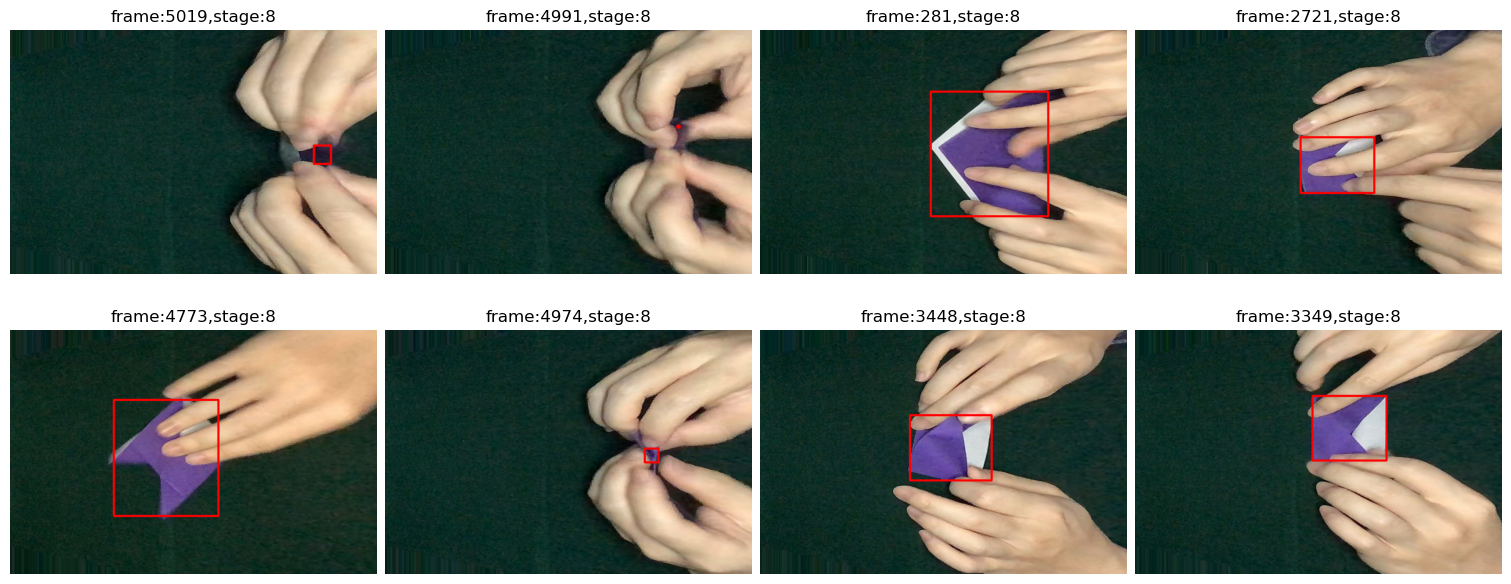

In [261]:
# visualize each stage
foldername = "data/dog_p_on_g_anno_homog"
img_list = []
title_list = []
img_list2 = []
for frame_index in [5019,4991,281,2721,4773,4974,3448,3349]:
    img = load_uint8_img(f"{foldername}/{frame_index}.jpg") 
    img2 = img.copy()
    bbox = color_threshold_bbox(img)
    x1,y1,x2,y2 = bbox
#     x1,y1, w,h = int(x1), int(y1), int(w), int(h)
    cv2.rectangle(img, (x1,y1), (x2,y2), color=(255,0,0), thickness=5)
    img_list.append(img)
    title_list.append(f"frame:{frame_index},stage:{i}")
    
    img_torch = torch.tensor( img2.astype(np.float32)/255, dtype=torch.float32).permute(2,0,1)
    bboxes, classes = detecor(img_torch[None])
    x1,y1,w,h = bboxes[0].tolist()
    cv2.rectangle(img2, (x1,y1), (x1+w,y1+h), color=(255,0,0), thickness=5)
    img_list2.append(img2)
    print("--------------------------------")
ic(len(img_list))
plot_tensor_image_grid(img_list, 4, titles=title_list, figsize=(15,6), transpose=False) 
# plt.savefig("anno_bbox_color-threshold.png", dpi=250)
# plt.show()

plot_tensor_image_grid(img_list2, 4, titles=title_list, figsize=(15,6), transpose=False) 

# Convert to CoreML

## Class wrapper

In [16]:
# np.load("ipad_homography_new.npy")

array([[ 9.06344204e-01, -8.11194431e-04, -1.27892548e+01],
       [-2.50120235e-01,  8.46349949e-01,  9.28360771e+01],
       [-6.35045392e-04, -8.80009709e-06,  1.00000000e+00]])

In [8]:
class OrigamiPaperDetectionModelWrapper(torch.nn.Module):
    """
    Wrap OrigamiPaperDetectionModel for convenient coreml use
    
    Changes:
        1. resize and crop
        2. homography transformation
    
    Other pre-processing needed within the APP:
        1. 
    """
    def __init__(self, detector: OrigamiPaperDetectionModel):
        super().__init__()
        self.detector = detector
        
#         self.w_offset = 350
#         self.w_offset_max = 1280
#         self.output_w = 1200
#         self.output_h = 800
#         self.homography = torch.tensor(np.load("ipad_homography_new.npy"), dtype=torch.float32).unsqueeze(0)
        
        ## need to add as parameter:
        ## https://github.com/apple/coremltools/issues/1355
        self.w_offset = nn.parameter.Parameter(torch.tensor(350, dtype=int), requires_grad=False)
        self.w_offset_max = nn.parameter.Parameter(torch.tensor(1280, dtype=int), requires_grad=False)
        self.output_w = nn.parameter.Parameter(torch.tensor(1200, dtype=int), requires_grad=False)
        self.output_h = nn.parameter.Parameter(torch.tensor(800, dtype=int), requires_grad=False)
        self.homography = nn.parameter.Parameter(
            torch.tensor(np.load("ipad_homography_new.npy"), dtype=torch.float32).unsqueeze(0), requires_grad=False)
        
#         self.preprocess = transforms.Compose([ # used in test transform
# #             transforms.ToTensor(),
# #             transforms.Resize((256,256), interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         ])
#         self.mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32).view(3,1,1)
#         self.std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32).view(3,1,1)
    
    def forward(self, img):  
        """
        img: [1,3, 720, 1280]
        """
        img = img[:,:,:,self.w_offset.item():self.w_offset_max.item()]
        img = kornia.geometry.transform.warp_perspective(
            img, torch.tensor([[ 9.06344204e-01, -8.11194431e-04, -1.27892548e+01],
                               [-2.50120235e-01,  8.46349949e-01,  9.28360771e+01],
                               [-6.35045392e-04, -8.80009709e-06,  1.00000000e+00]]).unsqueeze(0), 
             (800, 1200),
             padding_mode="border") # [1,3,800,1200]
#         B = img.shape[0]
#         img = img[:,:,:,self.w_offset:self.w_offset_max]
#         img = kornia.geometry.transform.warp_perspective(img, self.homography.expand(B,-1,-1), 
#                                                          (self.output_h, self.output_w),
#                                                          padding_mode="border")
#         img = torch.nn.functional.interpolate(img, (256,256))
#         img = (img - self.mean)/self.std
#         return self.detector(img)
        return img

### test image pre-processing

In [56]:
detector_scripted = torch.jit.script(OrigamiPaperDetectionModel())

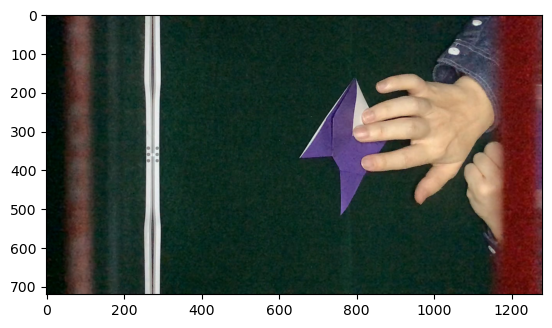

In [31]:
sample_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g/5311.jpg"
sample_img = np.asarray(Image.open(sample_path))
plt.imshow(sample_img)

#### Numpy

In [103]:
def fix_homography(img_path, flags=cv2.INTER_LANCZOS4):
    w_offset = 350
    w_offset_max = 1280
    new_shape = (1200,800)
    homography = np.load("ipad_homography_new.npy")

    img = plt.imread(img_path) #[H,W,3]
    img = img[:,w_offset:w_offset_max]
    warp_img = cv2.warpPerspective(img, homography, new_shape, 
                                   flags=flags,
                                   borderMode = cv2.BORDER_REPLICATE)
    return warp_img

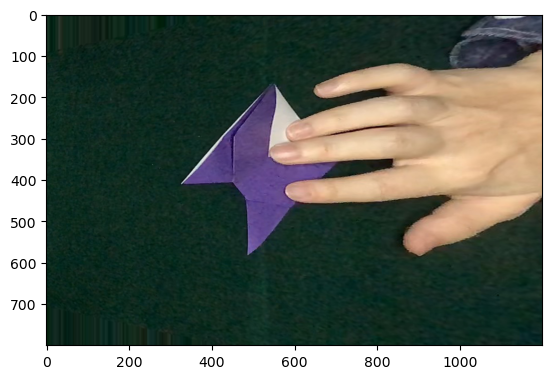

In [38]:
sample_img_np = fix_homography(sample_path)
plt.imshow(sample_img_np)

#### Torch

In [39]:
# load in to torch tensor
sample_img_torch = sample_img.astype(np.float32) / 255
sample_img_torch = torch.tensor(sample_img_torch, dtype=torch.float32).permute(2,0,1)

# test transform
detector_scripted = torch.jit.script(OrigamiPaperDetectionModel())
detectorWrapper = OrigamiPaperDetectionModelWrapper(detector_scripted)
img_transformed = detectorWrapper(sample_img_torch[None])[0]

# convert back
img_transformed = img_transformed.permute(1,2,0).numpy()
plt.imshow(img_transformed)

### test bbox detection result

In [69]:
img_id = 445

In [76]:
img_path = f"/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/{img_id}.jpg"
img = np.asarray(Image.open(img_path))
plt.imshow(img)

test in np

In [70]:
img_path = f"/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/{img_id}.jpg"
img = np.asarray(Image.open(img_path))
print(img.shape)
color_threshold_bbox_test(img) # x1,y1,x2,y2

(800, 1200, 3)
9416
111989
[ 65  65  65 ... 754 754 754] (121405,)
[668 669 670 ... 645 646 647] (121405,)


[309, 65, 679, 754]

In [108]:
img_path = f"/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/{img_id}.jpg"
img = np.asarray(Image.open(img_path)).astype(np.float32) / 255
img_torch = torch.tensor(img, dtype=torch.float32).permute(2,0,1)
detector_scripted(img_torch[None])

(tensor([[309,  65, 370, 689]], dtype=torch.int32), tensor([1.]))

test in torch

In [107]:
## transform in np, detect in torch
sample_path = f"/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g/{img_id}.jpg"
sample_img = fix_homography(sample_path)

sample_img_torch = sample_img.astype(np.float32) / 255
sample_img_torch = torch.tensor(sample_img_torch, dtype=torch.float32).permute(2,0,1)

# test transform
detector_scripted(sample_img_torch[None])

(tensor([[309,  63, 372, 692]], dtype=torch.int32), tensor([1.]))

In [110]:
## transform in np (bilinear), detect in torch
sample_path = f"/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g/{img_id}.jpg"
sample_img = fix_homography(sample_path, flags=cv2.INTER_LINEAR)

sample_img_torch = sample_img.astype(np.float32) / 255
sample_img_torch = torch.tensor(sample_img_torch, dtype=torch.float32).permute(2,0,1)
print(sample_img_torch.shape)

# test transform
detector_scripted(sample_img_torch[None])

torch.Size([3, 800, 1200])


(tensor([[309,  63, 372, 693]], dtype=torch.int32), tensor([1.]))

In [97]:
# load in to torch tensor
sample_path = f"/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g/{img_id}.jpg"
sample_img = np.asarray(Image.open(sample_path))
sample_img_torch = sample_img.astype(np.float32) / 255
sample_img_torch = torch.tensor(sample_img_torch, dtype=torch.float32).permute(2,0,1)

w_offset = 350
w_offset_max = 1280
output_w = 1200
output_h = 800
homography = torch.tensor(np.load("ipad_homography_new.npy"), dtype=torch.float32)[None]

img = sample_img_torch[None]
img = img[:,:,:,w_offset:w_offset_max]
img = kornia.geometry.transform.warp_perspective(img, homography.expand(1,-1,-1), 
                                                 (output_h, output_w),
                                                 padding_mode="border")
detector_scripted(img)

(tensor([[309,  63, 372, 693]], dtype=torch.int32), tensor([1.]))

In [82]:
## transform & detect in torch

# load in to torch tensor
sample_path = f"/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g/{img_id}.jpg"
sample_img = np.asarray(Image.open(sample_path))
sample_img_torch = sample_img.astype(np.float32) / 255
sample_img_torch = torch.tensor(sample_img_torch, dtype=torch.float32).permute(2,0,1)

# test transform
detectorWrapper = OrigamiPaperDetectionModelWrapper(detector_scripted)
detectorWrapper(sample_img_torch[None]) # x1,y1,w,h

(tensor([[309,  63, 372, 693]], dtype=torch.int32), tensor([1.]))

The result is the same as np if using bilinear interpolation for warp_perspective

#### The lossy compression issue

In [150]:
def fix_homography_folder(in_folder, out_folder):
    """ convert all img in in_folder """
    assert os.path.exists(in_folder)
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
    
    for img_name in tqdm(os.listdir(in_folder)):
        if img_name.endswith(".npz") or img_name.endswith(".txt"):
            shutil.copy2(os.path.join(in_folder, img_name), 
                         os.path.join(out_folder, img_name))
            continue
        if not img_name.endswith(".jpg"):
            continue
        warp_img = fix_homography(os.path.join(in_folder, img_name))
        temp_img = warp_img.copy()
        print(img_name, temp_img.dtype)
        print("1 vs 15",img1.shape, temp_img.shape)
        print(np.isclose(img1, temp_img).mean())
        warp_img = Image.fromarray(warp_img)
        warp_img.save(os.path.join(out_folder, img_name))
    print(f"Save img from {in_folder} to {out_folder}")
    return temp_img

In [151]:
in_folder = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/sample_dog"
out_folder = "data/sample_dog_homo"
img_wrapped = fix_homography_folder(in_folder, out_folder)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]

445.jpg uint8
1 vs 15 (800, 1200, 3) (800, 1200, 3)
0.30663263888888886
Save img from /Users/jameschen/Desktop/16622 MSCV Capston/Code/data/sample_dog to data/sample_dog_homo


In [163]:
# check in np
img_path = f"/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/{img_id}.jpg"
img1 = np.asarray(Image.open(img_path))

# redo the process  1.0
img_path = f"/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/sample_dog_homo/445.jpg"
img12 = np.asarray(Image.open(img_path))

print("redo the process, 1 vs 12",img1.shape, img12.shape)
print(np.isclose(img1, img12).mean())

## without saving  0.3
img13 = img_wrapped

print("without saving, 1 vs 13",img1.shape, img13.shape)
print(np.isclose(img1, img13).mean())

## all inline
img_path = f"/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g/445.jpg"
save_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/sample_dog_homo/445.png"
warp_img = fix_homography(img_path)
print("old_saved vs warp_img",img1.shape, warp_img.shape)
print(np.isclose(img1, warp_img).mean())

img16 = Image.fromarray(warp_img)
img162 = np.asarray(img16)
print("warp_img vs PIL conversion",warp_img.shape, img162.shape)
print(np.isclose(warp_img, img162).mean())

img16.save(save_path)
img16 = np.asarray(Image.open(save_path))
    
print("warp_img vs new_saved_png",warp_img.shape, img16.shape)
print(np.isclose(warp_img, img16).mean())

print("old_saved_jpg vs new_saved_png",img1.shape, img16.shape)
print(np.isclose(img1, img16).mean())

# sample_path = f"/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g/{img_id}.jpg"
# img2 = fix_homography(sample_path)

# print(img1.shape, img2.shape)
# np.isclose(img1, img2).mean()


redo the process, 1 vs 12 (800, 1200, 3) (800, 1200, 3)
1.0
without saving, 1 vs 13 (800, 1200, 3) (800, 1200, 3)
0.30663263888888886
old_saved vs warp_img (800, 1200, 3) (800, 1200, 3)
0.30663263888888886
warp_img vs PIL conversion (800, 1200, 3) (800, 1200, 3)
1.0
warp_img vs new_saved_png (800, 1200, 3) (800, 1200, 3)
1.0
old_saved_jpg vs new_saved_png (800, 1200, 3) (800, 1200, 3)
0.30663263888888886


Conclusion: the data that I saved are in jpg, which is not lossless, so the actual pixels are the same in png format, but slightly off in jpg.

### Run with real img

In [196]:
## transform & detect in torch
img_id = 445

# load in to torch tensor
sample_path = f"/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g/{img_id}.jpg"
sample_img = np.asarray(Image.open(sample_path))
sample_img_torch = sample_img.astype(np.float32) / 255
sample_img_torch = torch.tensor(sample_img_torch, dtype=torch.float32).permute(2,0,1)

# test transform
# detector_scripted = torch.jit.script(OrigamiPaperDetectionModel(), example_inputs={"img":torch.rand(1,3,800,1200)})
detector_scripted = torch.jit.script(OrigamiPaperDetectionModel())
detectorWrapper = OrigamiPaperDetectionModelWrapper(detector_scripted)
detectorWrapper(sample_img_torch[None]) # x1,y1,w,h

tensor([[[[0.0825, 0.0941, 0.0949,  ..., 0.9791, 0.9778, 0.9765],
          [0.0826, 0.0941, 0.0949,  ..., 0.9767, 0.9747, 0.9727],
          [0.0826, 0.0941, 0.0949,  ..., 0.9717, 0.9700, 0.9687],
          ...,
          [0.0365, 0.0244, 0.0157,  ..., 0.9704, 0.9700, 0.9697],
          [0.0365, 0.0244, 0.0157,  ..., 0.9720, 0.9724, 0.9719],
          [0.0365, 0.0243, 0.0157,  ..., 0.9671, 0.9678, 0.9686]],

         [[0.1647, 0.1647, 0.1655,  ..., 0.8462, 0.8467, 0.8470],
          [0.1647, 0.1647, 0.1655,  ..., 0.8447, 0.8439, 0.8432],
          [0.1647, 0.1647, 0.1655,  ..., 0.8397, 0.8392, 0.8392],
          ...,
          [0.1581, 0.1459, 0.1371,  ..., 0.7860, 0.7857, 0.7855],
          [0.1581, 0.1459, 0.1371,  ..., 0.7885, 0.7881, 0.7880],
          [0.1581, 0.1459, 0.1370,  ..., 0.7910, 0.7906, 0.7904]],

         [[0.1059, 0.1098, 0.1106,  ..., 0.7124, 0.7117, 0.7109],
          [0.1060, 0.1098, 0.1106,  ..., 0.7074, 0.7067, 0.7059],
          [0.1060, 0.1098, 0.1106,  ..., 0

## Convert

### Script the wrapper

In [179]:
sample_path = f"/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g/445.jpg"
sample_img = np.asarray(Image.open(sample_path))
sample_img = sample_img.astype(np.float32) / 255
sample_img = torch.tensor(sample_img, dtype=torch.float32).permute(2,0,1)
sample_img = sample_img[None]
sample_img.shape

torch.Size([1, 3, 720, 1280])

In [31]:
optimize_for_mobile = True

detector_scripted = torch.jit.script(OrigamiPaperDetectionModel().eval())
torch_model = OrigamiPaperDetectionModelWrapper(detector_scripted)
torch_model.eval()
example_input = sample_img

torch_out = torch_model(example_input)
print(torch_out) # (tensor([[309,  63, 372, 693]], dtype=torch.int32), tensor([1.]))

## complete disable backward graph or future autograd usage: https://pytorch.org/docs/stable/notes/autograd.html#locally-disable-grad-doc
## use for deployment to get performance gain: https://discuss.pytorch.org/t/does-torch-jit-script-requires-no-grad-and-eval-modes/132181/8
with torch.inference_mode(): 
#     torch_model_scripted = torch.jit.trace(torch_model, example_input)
    torch_model_scripted = torch.jit.script(torch_model)
    if optimize_for_mobile:
        ## check: https://pytorch.org/docs/1.13/mobile_optimizer.html?highlight=mobile_optimizer
        ## make sure to add useful methods (other than forward) in `preserved_methods`
        import torch.utils.mobile_optimizer as mobile_optimizer    
        torch_model_scripted = mobile_optimizer.optimize_for_mobile(torch_model_scripted)
    traced_out = torch_model_scripted(example_input)

print(traced_out)


tensor([[[[0.0392, 0.0392, 0.0431,  ..., 0.4039, 0.4196, 0.4353],
          [0.0353, 0.0353, 0.0431,  ..., 0.3961, 0.4078, 0.4196],
          [0.0353, 0.0353, 0.0431,  ..., 0.3843, 0.3882, 0.3922],
          ...,
          [0.0196, 0.0196, 0.0118,  ..., 0.4431, 0.4510, 0.4549],
          [0.0196, 0.0196, 0.0157,  ..., 0.4549, 0.4588, 0.4667],
          [0.0196, 0.0196, 0.0196,  ..., 0.4588, 0.4745, 0.4745]],

         [[0.1412, 0.1412, 0.1373,  ..., 0.1804, 0.2039, 0.2196],
          [0.1373, 0.1373, 0.1373,  ..., 0.1725, 0.1922, 0.2039],
          [0.1373, 0.1373, 0.1373,  ..., 0.1608, 0.1725, 0.1765],
          ...,
          [0.1490, 0.1451, 0.1333,  ..., 0.2000, 0.2078, 0.2118],
          [0.1490, 0.1451, 0.1373,  ..., 0.2039, 0.2157, 0.2235],
          [0.1490, 0.1451, 0.1412,  ..., 0.2078, 0.2235, 0.2314]],

         [[0.0902, 0.0902, 0.0863,  ..., 0.2039, 0.2235, 0.2392],
          [0.0863, 0.0863, 0.0863,  ..., 0.1961, 0.2118, 0.2235],
          [0.0863, 0.0863, 0.0863,  ..., 0

### Save as CoreML

In [9]:
with torch.inference_mode(): 
    detector_scripted = torch.jit.script(OrigamiPaperDetectionModel().eval())
torch_model_scripted = detector_scripted

sample_path = f"/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/445.jpg"
sample_img = np.asarray(Image.open(sample_path))
sample_img = sample_img.astype(np.float32) / 255
sample_img = torch.tensor(sample_img, dtype=torch.float32).permute(2,0,1)
sample_img = sample_img[None]
print(sample_img.shape)

torch_model_scripted(sample_img)

torch.Size([1, 3, 800, 1200])


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [10]:
with torch.inference_mode(): 
    detector_scripted = torch.jit.script(OrigamiPaperDetectionModel().eval())
torch_model_scripted = detector_scripted

image_input = ct.ImageType(name="input_image",shape=(1,3,800,1200), 
                           color_layout=ct.colorlayout.RGB,
                           scale=1/255., channel_first=True) # implicitly set channel_first=True to handle permute
#                           scale=1/(0.226*255.0), bias=[-0.485/(0.229), -0.456/(0.224), -0.406/(0.225)]) # implicitly set channel_first=True to handle permute
class_labels = [f"{str(i)}" for i in range(9)]
mlmodel = ct.convert(
    torch_model_scripted, source="pytorch",
    inputs=[image_input],
    outputs=[ct.TensorType(name='output_img', dtype=np.float32)],
#     outputs=[ct.TensorType(name='bbox', dtype=np.int32),
#              ct.TensorType(name='cls', dtype=np.float32)],
#     classifier_config = ct.ClassifierConfig(class_labels),
#     compute_units=ct.ComputeUnit.ALL,
#     minimum_deployment_target=ct.target.macOS10_15,
    debug=True
)

When both 'convert_to' and 'minimum_deployment_target' not specified, 'convert_to' is set to "mlprogram" and 'minimum_deployment_targer' is set to ct.target.iOS15 (which is same as ct.target.macOS12). Note: the model will not run on systems older than iOS15/macOS12/watchOS8/tvOS15. In order to make your model run on older system, please set the 'minimum_deployment_target' to iOS14/iOS13. Details please see the link: https://coremltools.readme.io/docs/unified-conversion-api#target-conversion-formats
Support for converting Torch Script Models is experimental. If possible you should use a traced model for conversion.
Converting PyTorch Frontend ==> MIL Ops:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 23/25 [00:00<00:00, 800.64 ops/s]


ValueError: Op "torch_result2.1" (op_type: conv) Input pad="torch_result2.1_pad_0" expects tensor or scalar of dtype from type domain ['int32'] but got tensor[4,fp32]

In [14]:
# convert the model going over ONNX.
with torch.inference_mode(): 
    detector_scripted = torch.jit.script(OrigamiPaperDetectionModel().eval())
torch_model_scripted = detector_scripted

torch.onnx.export(torch_model_scripted, (sample_img), "color_threshold_detector.onnx", verbose=True)
# coreml_model  = ct.converters.onnx.convert(model='color_threshold_detector.onnx', minimum_ios_deployment_target='13')

cml_model = ct.convert(
    model="color_threshold_detector.onnx",
    inputs=[image_input],
#     image_input_names=['input.1'],
#     preprocessing_args={
#         'image_scale': 1/255.0,
#             'is_bgr': False
#     },
#     minimum_ios_deployment_target='13', 
)


Exported graph: graph(%img.1 : Float(1, 3, 800, 1200, strides=[3, 1, 3600, 3], requires_grad=0, device=cpu)):
  %/Constant_output_0 : Long(1, strides=[1], device=cpu) = onnx::Constant[value={1}, onnx_name="/Constant"](), scope: OrigamiPaperDetectionModel:: # /var/folders/70/nttq9__s39n4qll4js828q980000gn/T/ipykernel_24645/151036747.py:37:15
  %/Constant_1_output_0 : Long(1, strides=[1], device=cpu) = onnx::Constant[value={0}, onnx_name="/Constant_1"](), scope: OrigamiPaperDetectionModel:: # /var/folders/70/nttq9__s39n4qll4js828q980000gn/T/ipykernel_24645/151036747.py:37:15
  %/Constant_2_output_0 : Long(1, strides=[1], device=cpu) = onnx::Constant[value={1}, onnx_name="/Constant_2"](), scope: OrigamiPaperDetectionModel:: # /var/folders/70/nttq9__s39n4qll4js828q980000gn/T/ipykernel_24645/151036747.py:37:15
  %/Constant_3_output_0 : Long(1, strides=[1], device=cpu) = onnx::Constant[value={1}, onnx_name="/Constant_3"](), scope: OrigamiPaperDetectionModel:: # /var/folders/70/nttq9__s39n4ql

ValueError: Unable to determine the type of the model, i.e. the source framework. Please provide the value of argument "source", from one of ["tensorflow", "pytorch", "milinternal"]. Note that model conversion requires the source package that generates the model. Please make sure you have the appropriate version of source package installed. E.g., if you're converting model originally trained with TensorFlow 1.14, make sure you have `tensorflow==1.14` installed.

%torch_result_final)



In [ ]:
torch

In [55]:
with torch.inference_mode(): 
    detector_scripted = torch.jit.script(OrigamiPaperDetectionModel().eval())
torch_model_scripted = detector_scripted
# torch_model = OrigamiPaperDetectionModelWrapper(detector_scripted)
torch_model = OrigamiPaperDetectionModelWrapper(None)
torch_model.eval()
example_input = sample_img

torch_out = torch_model(example_input)
print(torch_out) # (tensor([[309,  63, 372, 693]], dtype=torch.int32), tensor([1.]))

## complete disable backward graph or future autograd usage: https://pytorch.org/docs/stable/notes/autograd.html#locally-disable-grad-doc
## use for deployment to get performance gain: https://discuss.pytorch.org/t/does-torch-jit-script-requires-no-grad-and-eval-modes/132181/8
with torch.inference_mode(): 
    torch_model_scripted = torch.jit.trace(torch_model, example_input)
#     torch_model_scripted = torch.jit.script(torch_model)

In [ ]:
torch_out.shape

In [52]:
import coremltools as ct
# Convert to Core ML program using the Unified Conversion API.

# ## TensorType input
# mlmodel = ct.convert(
#     traced_model,
# #     convert_to="mlprogram",
#     inputs=[ct.TensorType(shape=example_input.shape, name='input_image', dtype=np.float32)],
#     outputs=[ct.TensorType(name='output_logits', dtype=np.float32)],
# #     compute_precision=ct.precision.FLOAT32
# )

# ## deploy at mac10.15
# mlmodel = ct.convert(
#     traced_model,
# #     convert_to="mlprogram",
#     inputs=[ct.TensorType(shape=example_input.shape, name='input_image', dtype=np.float32)],
#     outputs=[ct.TensorType(name='output_logits', dtype=np.float32)],
#     minimum_deployment_target=ct.target.macOS10_15
# )

# ## use imagetype input: 
# ## from transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# # scale = [1/(0.229*255.0), 1/(0.224*255.0), 1/(0.225*255.0)]
# scale = 1/(0.226*255.0) # only accept one float/int
# bias = [- 0.485/(0.229) , - 0.456/(0.224), - 0.406/(0.225)]

# image_input = ct.ImageType(name="input_image",
#                            shape=example_input.shape,
#                            scale=scale, bias=bias) # implicitly set channel_first=True to handle permute
# mlmodel = ct.convert(
#     traced_model,
#     inputs=[image_input],
#     outputs=[ct.TensorType(name='output')],
#     compute_units=ct.ComputeUnit.CPU_ONLY
# )

## output logits, and use imagetype input and class_labels as ClassifierConfig: 
image_input = ct.ImageType(name="input_image",shape=sample_img.shape, 
                           color_layout=ct.colorlayout.RGB,
                           scale=1/255., channel_first=True) # implicitly set channel_first=True to handle permute
#                           scale=1/(0.226*255.0), bias=[-0.485/(0.229), -0.456/(0.224), -0.406/(0.225)]) # implicitly set channel_first=True to handle permute
class_labels = [f"{str(i)}" for i in range(9)]
mlmodel = ct.convert(
    torch_model_scripted, source="pytorch",
    inputs=[image_input],
    outputs=[ct.TensorType(name='output_img', dtype=np.float32)],
#     outputs=[ct.TensorType(name='bbox', dtype=np.int32),
#              ct.TensorType(name='cls', dtype=np.float32)],
#     classifier_config = ct.ClassifierConfig(class_labels),
    compute_units=ct.ComputeUnit.ALL,
    minimum_deployment_target=ct.target.macOS10_15,
    debug=True
)


Support for converting Torch Script Models is experimental. If possible you should use a traced model for conversion.
Converting PyTorch Frontend ==> MIL Ops:  24%|████████████████████████████▊                                                                                          | 61/252 [00:00<00:00, 6960.46 ops/s]

the following model ops are IMPLEMENTED:
  __getitem__
  _internal_op_tensor_inplace_copy_
  abs
  add
  bmm
  constant
  device
  div
  dtype
  eq
  expand
  floordiv
  grid_sampler
  gt
  if
  int
  item
  linspace
  listconstruct
  listunpack
  lt
  matmul
  meshgrid
  mul
  ne
  neg
  ones_like
  pad
  permute
  reciprocal
  repeat_interleave
  reshape
  select
  size
  slice
  squeeze
  stack
  sub
  tensor
  to
  tupleconstruct
  tupleunpack
  unsqueeze
  where
the following model ops are MISSING:
  __contains__
  __not__
  _set_item
  format
  len
  linalg_inv
  list
  raiseexception


RuntimeError: PyTorch convert function for op 'len' not implemented.

In [ ]:
mlmodel.save("optized_origami_resnet_v2.mlmodel")